In [3]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense, Input, LSTM, concatenate, Embedding,multiply,Lambda
from keras import backend as K
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime
from log import _check_log_directory,_initialise_model_log
from operator import itemgetter
from keras.utils import plot_model
import pickle
from load_features import load_features
from nltk.corpus import stopwords

/Users/Michael/Library/Python/2.7/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [5]:
data_dir = "data/"
log_dir = './log'

In [6]:
features_train, features_test, data_train = load_features(data_dir)
data_test = pd.read_csv(data_dir+'test.csv', sep=',',names = ["id", "qid1", "qid2", "question1","question2","is_duplicate"])

In [7]:
X = features_train.drop(['is_duplicate'],axis=1)
X_test = features_test
X = X.replace([np.inf, -np.inf], np.nan)
X = X .fillna(value=0)
X_test=X_test.replace([np.inf, -np.inf], np.nan)
X_test=X_test.fillna(value=0)
Y = data_train["is_duplicate"].values

In [8]:
X.columns

Index([      u'len_q1',       u'len_q2',     u'diff_len',  u'len_char_q1',
        u'len_char_q2',  u'len_word_q1',  u'len_word_q2', u'common_words',
        u'fuzz_qratio',  u'fuzz_WRatio',
       ...
           u'num_w_q1',     u'num_w_q2',     u'num_v_q1',     u'num_v_q2',
           u'num_y_q1',     u'num_y_q2',     u'num_x_q1',     u'num_x_q2',
           u'num_z_q1',     u'num_z_q2'],
      dtype='object', length=158)

# Fully connected neural network

In [9]:
data = X
test_size = 0.1
X_train, X_val, Y_train, Y_val = train_test_split(data, Y, test_size=test_size)
del data
gc.collect()

578

In [10]:
number_of_features = X.values.shape[1]
print "number of features =", number_of_features

number of features = 158


## First training phase 

In [10]:
X_train_np = X_train.values
X_val_np = X_val.values
Y_train_np = Y_train
Y_val_np  = Y_val

shape = (X_train_np.shape[1],)
model = Sequential()
model.add(Dense(1024, activation='sigmoid',input_shape=shape))
model.add(Dense(1,activation = "sigmoid"))
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt)


weights_path = os.path.join(data_dir,'weights_1hidden_layer')
weights_path_best = weights_path + ".best.h5"
weights_path_last = weights_path + ".last.h5"
checkpoint_best = ModelCheckpoint(weights_path_best, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
checkpoint_last = ModelCheckpoint(weights_path_last, verbose=1, save_weights_only=True, period=2)
callbacks = [checkpoint_best,checkpoint_last]
history = model.fit(X_train_np,Y_train_np,epochs=20,validation_data =(X_val_np,Y_val_np),callbacks=callbacks)

Train on 72090 samples, validate on 8010 samples
Epoch 1/2
72000/72090 [============================>.] - ETA: 0s - loss: 0.5213
Epoch 00001: val_loss improved from inf to 0.36622, saving model to data/weights_1hidden_layer.best.h5
72090/72090 [==============================] - 11s 150us/step - loss: 0.5212 - val_loss: 0.3662
Epoch 2/2
72064/72090 [============================>.] - ETA: 0s - loss: 0.3049
Epoch 00002: val_loss improved from 0.36622 to 0.28652, saving model to data/weights_1hidden_layer.best.h5

Epoch 00002: saving model to data/weights_1hidden_layer.last.h5
72090/72090 [==============================] - 8s 114us/step - loss: 0.3048 - val_loss: 0.2865


## Second training phase 

In [13]:
opt = keras.optimizers.Adam(lr=0.00001)
model.compile(loss='binary_crossentropy', optimizer=opt)
history2 = model.fit(X_train_np,Y_train_np,epochs=15,validation_data =(X_val_np,Y_val_np),callbacks=callbacks)

Train on 72090 samples, validate on 8010 samples
Epoch 1/2
72032/72090 [============================>.] - ETA: 0s - loss: 0.2267
Epoch 00001: val_loss improved from 0.22754 to 0.22145, saving model to data/weights_1hidden_layer.best.h5
72090/72090 [==============================] - 8s 116us/step - loss: 0.2268 - val_loss: 0.2214
Epoch 2/2
71680/72090 [============================>.] - ETA: 0s - loss: 0.2217
Epoch 00002: val_loss improved from 0.22145 to 0.21588, saving model to data/weights_1hidden_layer.best.h5

Epoch 00002: saving model to data/weights_1hidden_layer.last.h5
72090/72090 [==============================] - 8s 115us/step - loss: 0.2219 - val_loss: 0.2159


## Plot losses

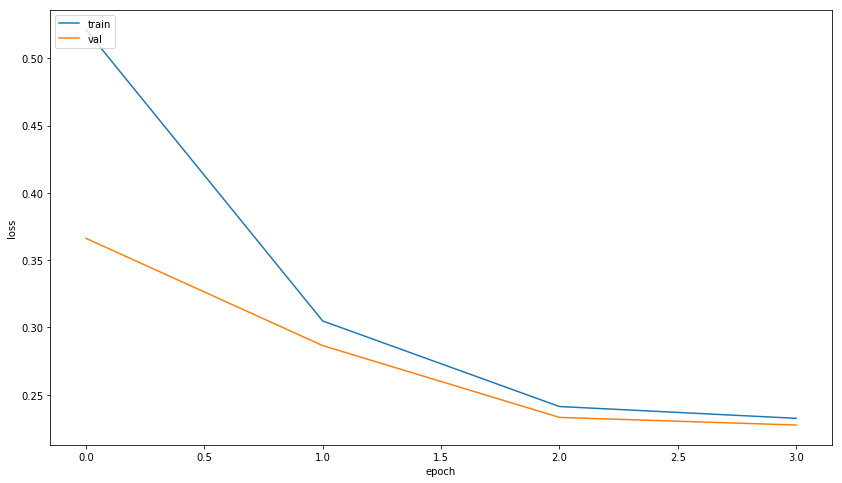

In [12]:
plt.rcParams["figure.figsize"] = (14,8)
plt.plot(history.history["loss"]+history2.history["loss"])
plt.plot(history.history["val_loss"]+history2.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

## Load best model and predict

In [11]:
model.load_weights(weights_path_best)
pred = model.predict([X_test])

## save result in csv

In [12]:
df_pred = pd.DataFrame(pred)
df_pred.index = X_test.index
df_pred.columns = ["Score"]
df_pred.to_csv("data/submission_file_FCNN_1hidden1024_99features_0,21.csv",index_label="Id")
df_pred.describe()

,Score
count,20179.000000
mean,0.633585
std,0.384509
min,0.070447
25%,0.191852
50%,0.942075
75%,0.967982
max,0.999991


# LSTM
## Choose if removing stopwords

In [11]:
remove_stopwords = False

## Compute maximal question length

In [12]:
q1_train = data_train["question1"]
q2_train = data_train["question2"]
q1_test = data_test["question1"]
q2_test = data_test["question2"]

In [13]:
q1_train_sp = [q.lower().replace('?','').split() for q in q1_train]
q2_train_sp = [q.lower().replace('?','').split() for q in q2_train]
q1_test_sp = [q.lower().replace('?','').split() for q in q1_test]
q2_test_sp = [q.lower().replace('?','').split() for q in q2_test]

if remove_stopwords:
    stop_words = stopwords.words('english')
    q1_train_sp = [[w for w in q if w not in stop_words ] for q in q1_train_sp]
    q2_train_sp = [[w for w in q if w not in stop_words ] for q in q2_train_sp]
    q1_test_sp =  [[w for w in q if w not in stop_words ] for q in q1_test_sp]
    q2_test_sp =  [[w for w in q if w not in stop_words ] for q in q2_test_sp]

In [14]:
m1 =  max([len(q) for q in q1_train_sp])
m2 =  max([len(q) for q in q2_train_sp])
m3 =  max([len(q) for q in q1_test_sp])
m4 =  max([len(q) for q in q2_test_sp])
print m1,m2,m3,m4

65 58 73 49


In [15]:
seq_length = max([m1,m2,m3,m4]) # maximum word per question 

## Count words and convert it to index (ordered in occurences)

In [16]:
words = {}
for i in range(len(q1_train_sp)):
    for q in q1_train_sp[i]:
        if q in words:
            words[q] += 1
        else:
            words[q] = 1
for i in range(len(q2_train_sp)):
    for q in q2_train_sp[i]:
        if q in words:
            words[q] += 1
        else:
            words[q] = 1
            
sorted_words = sorted(words.items(),key=itemgetter(1), reverse=True)
words_index ={}
for num,couple in enumerate(sorted_words):
    words_index[couple[0]] = num + 1

num_words = len(sorted_words)
print "Nombre de mot dans le vocabulaire de train :",num_words

def get_index(word,vocab):
    if word in vocab:
        return vocab[word]
    return 0
q1_train_sp_ind = [ [get_index(word,words_index) for word in sentence] for sentence in q1_train_sp]
q2_train_sp_ind = [ [get_index(word,words_index) for word in sentence] for sentence in q2_train_sp]
q1_test_sp_ind = [ [get_index(word,words_index) for word in sentence] for sentence in q1_test_sp]
q2_test_sp_ind = [ [get_index(word,words_index) for word in sentence] for sentence in q2_test_sp]

Nombre de mot dans le vocabulaire de train : 23059


## Zero pad questions to have same length to make it ok for LSTM input

In [17]:
q1_train_sp_ind_pad = sequence.pad_sequences(q1_train_sp_ind, maxlen=seq_length,padding='post')
q2_train_sp_ind_pad = sequence.pad_sequences(q2_train_sp_ind, maxlen=seq_length,padding='post')
q1_test_sp_ind_pad = sequence.pad_sequences(q1_test_sp_ind, maxlen=seq_length,padding='post')
q2_test_sp_ind_pad = sequence.pad_sequences(q2_test_sp_ind, maxlen=seq_length,padding='post')

In [18]:
test_size = 0.1
q1_train,q1_val,q2_train,q2_val,X_train,X_val,Y_train,Y_val = train_test_split(q1_train_sp_ind_pad,q2_train_sp_ind_pad,X,Y, test_size=test_size)

## LSTM Without features

In [19]:
embedding_dim = 300 # embeding size
dropout_rate = 0.5

lstm_input1 = Input(shape=(seq_length,), name='question1')
lstm_input2 = Input(shape=(seq_length,), name='question2')

E_layer = Embedding(num_words, embedding_dim, weights=None, input_length=seq_length, trainable=True,mask_zero=True,name='Words_embedding')
emb1 = E_layer(lstm_input1)
emb2 = E_layer(lstm_input2)

lstm_layer = LSTM(units=512,dropout=dropout_rate,name='LSTM')
lstm1 = lstm_layer(emb1)
lstm2 = lstm_layer(emb2)
x = multiply([lstm1,lstm2],name="Merge")
x = Dense(1024, activation='sigmoid',name="Fully_connected")(x)
x = Dense(1, activation='sigmoid',name="Output")(x)
model = Model(inputs=[lstm_input1,lstm_input2],outputs=x)

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question1 (InputLayer)          (None, 73)           0                                            
__________________________________________________________________________________________________
question2 (InputLayer)          (None, 73)           0                                            
__________________________________________________________________________________________________
Words_embedding (Embedding)     (None, 73, 300)      6917700     question1[0][0]                  
                                                                 question2[0][0]                  
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, 512)          1665024     Words_embedding[0][0]            
          

# Create the image that represents the model

In [22]:
plot_model(model,to_file='model_lstm_no_features.png')

In [ ]:
opt = keras.optimizers.RMSprop(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt)
weights_path = os.path.join(data_dir,'weights_LSTM')
weights_path_best = weights_path + ".best.h5"
weights_path_last = weights_path + ".last.h5"
checkpoint_best = ModelCheckpoint(weights_path_best, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
checkpoint_last = ModelCheckpoint(weights_path_last, verbose=1, save_weights_only=True, period=2)
callbacks = [checkpoint_best,checkpoint_last]
history = model.fit([q1_train,q2_train],Y_train,epochs=10,validation_data =([q1_val,q2_val],Y_val),callbacks=callbacks,batch_size=512)

In [ ]:
opt = keras.optimizers.RMSprop(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt)
history2 = model.fit([np.vstack([q1_train,q2_train]),np.vstack([q2_train,q1_train])],np.hstack([Y_train,Y_train]),epochs=5,validation_data =([q1_val,q2_val],Y_val),callbacks=callbacks,batch_size=512)

In [ ]:
plt.rcParams["figure.figsize"] = (14,8)
plt.plot(history.history["loss"]+history2.history["loss"])
plt.plot(history.history["val_loss"]+history2.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

## Load best model and predict

In [ ]:
model.load_weights(weights_path_best)
pred = model.predict([X_test])

## save result in csv

In [ ]:
df_pred = pd.DataFrame(pred)
df_pred.index = X_test.index
df_pred.columns = ["Score"]
df_pred.to_csv("data/submission_file_LSTM_no_features.csv",index_label="Id")
df_pred.describe()

# LSTM with features

In [26]:
embedding_dim = 300 # embeding size
dropout_rate = 0.5

lstm_input1 = Input(shape=(seq_length,), name='question1')
lstm_input2 = Input(shape=(seq_length,), name='question2')
input_features = Input(shape=(number_of_features,), name='Features')

E_layer = Embedding(num_words, embedding_dim, weights=None, input_length=seq_length, trainable=True,mask_zero=True,name='Words_embedding')
emb1 = E_layer(lstm_input1)
emb2 = E_layer(lstm_input2)

lstm_layer = LSTM(units=512,dropout=dropout_rate,name="LSTM")
lstm1 = lstm_layer(emb1)
lstm2 = lstm_layer(emb2)
norm = Lambda(lambda feature : K.l2_normalize(feature),name="L2_normalization")
lstm1_norm = norm(lstm1)
lstm2_norm = norm(lstm2)
#x = multiply([lstm1_norm,lstm2_norm],name="Merge_questions")
#x = concatenate([x,input_features],name="Merge")
x = concatenate([lstm1_norm,lstm2_norm,input_features],name="Merge")
x = Dense(1024, activation='sigmoid',name="Fully_connected")(x)
x = Dense(1, activation='sigmoid',name="Output")(x)
model = Model(inputs=[lstm_input1,lstm_input2,input_features],outputs=x)

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question1 (InputLayer)          (None, 73)           0                                            
__________________________________________________________________________________________________
question2 (InputLayer)          (None, 73)           0                                            
__________________________________________________________________________________________________
Words_embedding (Embedding)     (None, 73, 300)      6917700     question1[0][0]                  
                                                                 question2[0][0]                  
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, 512)          1665024     Words_embedding[0][0]            
          

In [25]:
plot_model(model,to_file='model_lstm_with_features.png')

In [ ]:
opt = keras.optimizers.RMSprop(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt)
weights_path = os.path.join(data_dir,'weights_LSTM_features')
weights_path_best = weights_path + ".best.h5"
weights_path_last = weights_path + ".last.h5"
checkpoint_best = ModelCheckpoint(weights_path_best, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
checkpoint_last = ModelCheckpoint(weights_path_last, verbose=1, save_weights_only=True, period=2)
callbacks = [checkpoint_best,checkpoint_last]
history = model.fit([q1_train,q2_train,X_train],Y_train,epochs=15,validation_data =([q1_val,q2_val,X_val],Y_val),callbacks=callbacks,batch_size=512)

In [ ]:
opt = keras.optimizers.sgd(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt)
history2 =  model.fit([q1_train,q2_train,X_train],Y_train,epochs=15,validation_data =([q1_val,q2_val,X_val],Y_val),callbacks=callbacks,batch_size=512)

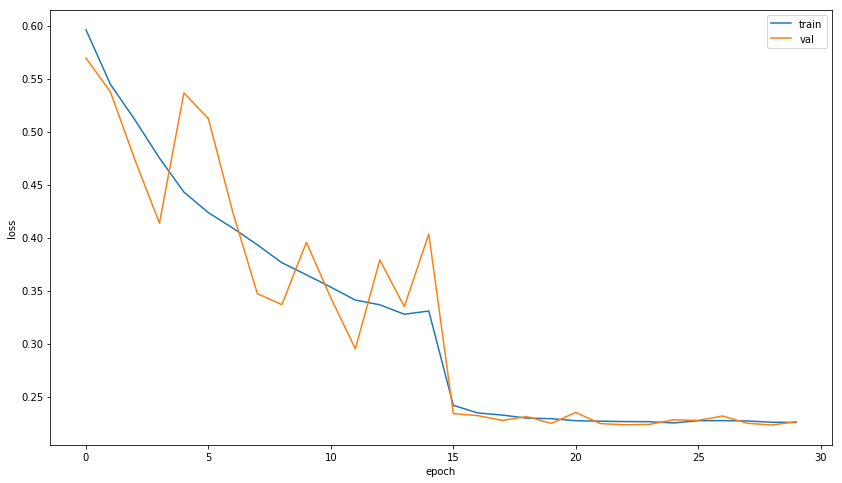

In [40]:
plt.rcParams["figure.figsize"] = (14,8)
plt.plot(history.history["loss"]+history2.history["loss"])
plt.plot(history.history["val_loss"]+history2.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

## Load best model and predict

In [ ]:
model.load_weights(weights_path_best)
pred = model.predict([X_test])

## save result in csv

In [ ]:
df_pred = pd.DataFrame(pred)
df_pred.index = X_test.index
df_pred.columns = ["Score"]
df_pred.to_csv("data/submission_file_LSTM_with_features.csv",index_label="Id")
df_pred.describe()